## Load the Motion Data

Data is in x and y coordinates for each pixel. Each sample will be an array of 10 (frames) x 40 x 40 (capture window) x 2 (x and y) dimensions. 

In [53]:
import os
import numpy as np
import matplotlib
matplotlib.use('TkAgg') # For displaying animation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn import linear_model as lm
from sklearn import svm as svm
from helper_functions import *
from normalize_data import *
from numpy import array
from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

%matplotlib notebook

/Users/justinshenk/anaconda3/envs/cvloop/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Load raw data for preprocessing

In [54]:
RAW_DATA_DIR = 'sonic_pi_face/data/'

# Get list of data files
data_files = get_data_files(RAW_DATA_DIR)

# Load data into a dictionary
# Note: Checks for incomplete data
data_dict = get_gesture_data(data_files)

## Visualize optical flow sample frame (Optional)

In [55]:
gestures = list(data_dict)
print(gestures) # List gestures
sample = data_dict['open-close'][3] # 3rd Open-close sample
image = sample[4] # 5th frame of sample
# plt.imshow(image)
# plt.show()

['slide-vertically', 'waving-beauty-pageant-style', 'slide-horizontally', 'empty', 'open-close']


## Visualize horizontal motion across frames (Optional)

In [56]:
sample = data_dict['open-close'][5] # Fifth sample
# anim = display_frames(sample)

# Feature Engineering

## WIP - Histogram of Gradients

(array([  8.58e-08,   4.29e-08,   0.00e+00,   8.58e-08,   3.00e-07,
          8.15e-07,   9.01e-07,   1.07e-06,   1.54e-06,   4.03e-06,
          5.19e-06,   7.08e-06,   2.72e-05,   2.15e-04,   4.32e-03,
          8.67e-02,   6.09e-04,   5.31e-05,   1.07e-05,   1.07e-06]),
 array([-166.12, -155.24, -144.37, -133.5 , -122.62, -111.75, -100.87,
         -90.  ,  -79.13,  -68.25,  -57.38,  -46.51,  -35.63,  -24.76,
         -13.88,   -3.01,    7.86,   18.74,   29.61,   40.48,   51.36]),
 <a list of 20 Patch objects>)

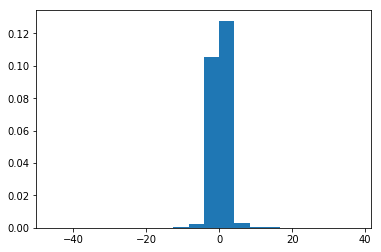

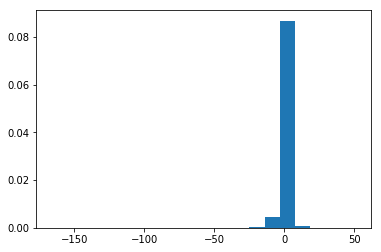

In [93]:
data_open_close = np.asarray(data_dict['open-close'])
x_values = data_open_close[...,0].flatten()
y_values = data_open_close[...,1].flatten()
plt.hist(x_values,bins=20, normed=True)
plt.subplots()
plt.hist(y_values,bins=20, normed=True)
data_empty = np.asarray(data_dict['empty'])
x_values = data_empty[...,0].flatten()
y_values = data_empty[...,1].flatten()
plt.subplots()
plt.hist(x_values,bins=20,normed=True)
plt.subplots()
plt.hist(y_values,bins=20,normed=True)

## Feature optimization for hyperparameter search

In [57]:
# Load all pre-processed data sets if available.
data_sets = []
DATA_DIR = 'data'

# Number of rows and colums to permute for optical flow feature extraction
divs=[4,10,20]

if os.path.exists(DATA_DIR):
    for file in os.listdir(DATA_DIR):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(DATA_DIR,file))
            df = df.drop('Unnamed: 0',axis=1)
            data_sets.append(df)
else:
    # Generate data sets.
    print("Directory not found at {}\nPreprocessing data for "
        "optimization.".format(os.path.join(os.getcwd(),DATA_DIR)))
    data_sets = make_feature_sets(data_dict,divs=divs)
    save_data_sets(data_sets,divs=divs)

## Feature extraction
### Extract various integral images of frames (Optional)

In [58]:
# Dataframe with 32 (16 * 2 (x and y coordinates)) dimensions
df_red = feature_extract(data_dict,cols=4,rows=4)

## Hyper-parameter Optimization
### Use random forests for hyperparameter optimization. (Optional)

Confusion matrix, without normalization
[[75  1  3  2]
 [ 4 21  4  4]
 [ 9  0 16  0]
 [ 3  4  3 21]]


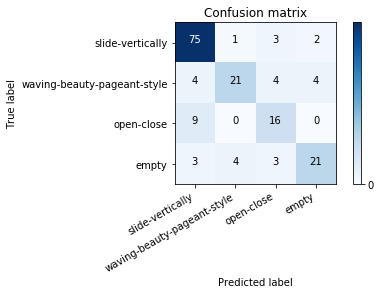

Score for 4x4:
0.7823529411764706
Confusion matrix, without normalization
[[76  0  3  2]
 [ 3 26  3  1]
 [ 9  2 14  0]
 [ 5  5  3 18]]


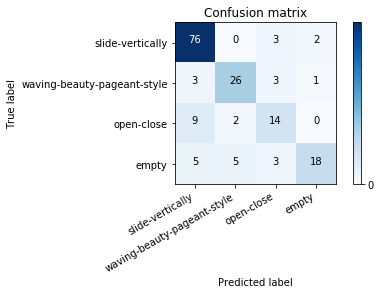

Score for 4x10:
0.788235294117647
Confusion matrix, without normalization
[[20  5  1 14]
 [ 1 27  2  3]
 [ 2  3 26  3]
 [ 4  0  1 58]]


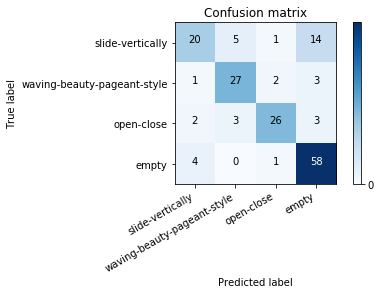

Score for 4x20:
0.7705882352941177
Confusion matrix, without normalization
[[75  2  2  2]
 [ 2 23  5  3]
 [ 9  2 13  1]
 [ 3  8  4 16]]


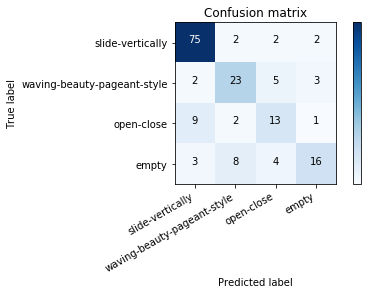

Score for 10x4:
0.7470588235294118
Confusion matrix, without normalization
[[75  3  1  2]
 [ 2 24  4  3]
 [ 7  1 16  1]
 [ 4  6  2 19]]


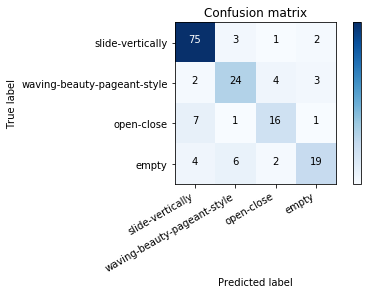

Score for 10x10:
0.788235294117647
Confusion matrix, without normalization
[[27  3  0 10]
 [ 4 25  0  4]
 [ 6  2 23  3]
 [ 6  1  2 54]]


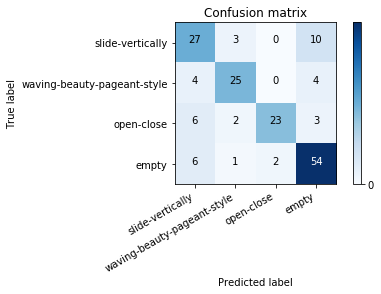

Score for 10x20:
0.7588235294117647
Confusion matrix, without normalization
[[25  4  1 10]
 [ 4 27  0  2]
 [ 3  3 25  3]
 [ 3  0  2 58]]


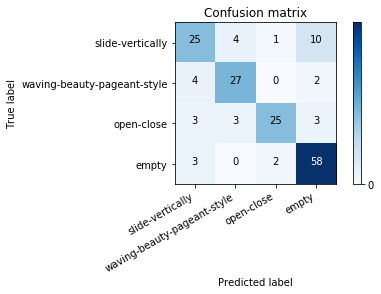

Score for 20x4:
0.7941176470588235
Confusion matrix, without normalization
[[24  3  1 12]
 [ 1 25  2  5]
 [ 3  4 24  3]
 [ 7  0  1 55]]


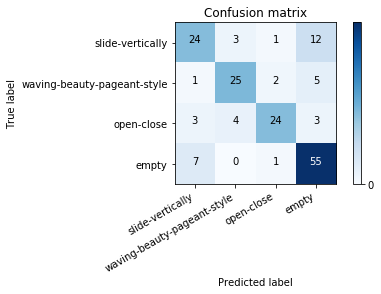

Score for 20x10:
0.7529411764705882
Confusion matrix, without normalization
[[23  3  0 14]
 [ 2 25  0  6]
 [ 5  2 25  2]
 [ 5  0  0 58]]


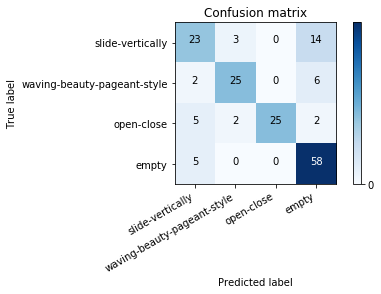

Score for 20x20:
0.7705882352941177


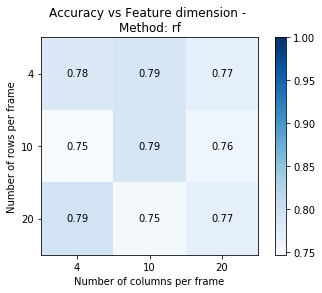

In [59]:
%matplotlib inline
ax = optimize_feature_dimensions(data_sets,divs,method='rf') # also use method='ada'
plt.show()

## Perform classification

In [60]:
data = data_sets[0] # Choose middle (or argmax) feature set
gestures=['open-close','empty','waving-beauty-pageant-style']

# Pandas dataframe `data`
data = data[data['label'].isin(gestures)]
data.head()
data, targets = encode_target(data, 'label') # Encode target column

# Split into features and target
X, Y = class_split(data,gestures=gestures)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

## Multiclass Random Forest Classification

In [61]:
# Classify test data using random forest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
accuracy = clf.score(X_test,y_test)

print("Predictions:\n{}".format(clf.predict(X_test)))
print("Actual:\n{}".format(y_test[:10]))
print("Score:\n{}".format(accuracy))

Predictions:
[2 2 1 2 0 0 0 0 1 0 0 1 2 0 0 0 2 0 0 2 0 0 0 1 0 0 0 1 0 1 0 0 0 0 2 2 2
 1 0 2 0 1 0 0 1 2 0 0 0 1 0 2 0 0 0 0 0 2 1 2 0 2 2 2 0 2 0 1 1 0 0 0 0 2
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 1 0 2 1 0 1 0 0 0 2 0 2 0 0 0 1 0 0
 1 2 1 0 1 2 1 1 0 1 0 2 0 2 0 2 2 0 0 0 2 1 0 0 2]
Actual:
791    2
739    2
488    1
792    2
456    1
77     0
132    0
76     0
84     0
196    0
Name: Target, dtype: int64
Score:
0.8014705882352942


## Adaboost

In [62]:
clf_adaboost = AdaBoostClassifier(DecisionTreeClassifier(
        max_depth=3), n_estimators=10)
clf_adaboost = clf_adaboost.fit(X_train, y_train)
accuracy = clf_adaboost.score(X_test, y_test)
print("Predictions:\n{}".format(clf_adaboost.predict(X_test)))
print("Actual:\n{}".format(y_test[:10]))
print("Score:\n{}".format(accuracy))

Predictions:
[2 2 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 1 0 0 0 1 0 1 1 1 0 0 2 0 2
 0 0 2 0 1 0 0 1 2 1 0 0 1 0 1 0 0 0 0 0 2 0 2 1 2 1 2 0 2 0 1 1 0 0 0 0 2
 0 1 1 1 0 0 0 1 0 2 0 0 0 0 0 0 0 1 0 1 0 2 0 1 1 0 0 0 2 0 1 0 0 1 1 0 0
 0 2 1 1 1 1 1 2 0 1 0 2 0 2 0 1 2 1 1 0 1 0 1 0 1]
Actual:
791    2
739    2
488    1
792    2
456    1
77     0
132    0
76     0
84     0
196    0
Name: Target, dtype: int64
Score:
0.7058823529411765


## Bagging

In [63]:
clf_bagging = BaggingClassifier()
clf_bagging = clf_bagging.fit(X_train, y_train)
print(clf_bagging.score(X_test, y_test))

0.845588235294


## Extra Trees

In [64]:
clf_extra_tree = ExtraTreesClassifier()
clf_extra_tree = clf_extra_tree.fit(X_train, y_train)
print(clf_extra_tree.score(X_test, y_test))

0.816176470588


## Gradient Boosting

In [65]:
clf_gradient_boosting = GradientBoostingClassifier()
clf_gradient_boosting = clf_gradient_boosting.fit(X_train, y_train)
print(clf_gradient_boosting.score(X_test,y_test))
# print("Predictions:\n{}".format(clf_bagging.predict(X_test)))
# print("Actual:\n{}".format(y_test))

0.852941176471


## Multilayer Perceptron

In [66]:
clf_mlpc = mlpc()
clf_mlpc = clf_mlpc.fit(X_train, y_train)
print(clf_mlpc.score(X_test,y_test))

0.735294117647


/Users/justinshenk/anaconda3/envs/cvloop/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


## SVM

In [67]:
clf_svm = svm.SVC(decision_function_shape='ovo')
clf_svm = clf_svm.fit(X_train, y_train)
print(clf_svm.score(X_test,y_test))

0.529411764706
